Notebook to train the DQN model and plot learning curve. 

### Prerequisites:
- ./extras/DQN_plus_{5_000_000}_steps.zip
- ./extras/DQN_280000_steps.zip

### OR:
- run the training for 1000 EPOCHS 
- WARNING: takes ~ 6 hours for training 1_000 EPOCHS
~ 7 hours to plot learning curve for 500 EPOCHS

In [42]:
import os
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
import numpy as np

from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy


from stable_baselines.common.callbacks import CheckpointCallback

from ads_utils import load_data, plot, Environment, write_to_logs, moving_average
from tqdm import tqdm

import time

In [65]:
# model learn timesteps(10_000 * EPOCHS)
EPOCHS = 500
start_time = time.time()

env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = DQN(MlpPolicy, env_learn, learning_rate=0.00001, batch_size=50, seed=1, verbose=0, double_q=True)

# use callback to save model!
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path='./checkpoint_logs/DQN/',
                                         name_prefix='DQN')

# save at every 1k timestep
model.learn(10_000*EPOCHS, callback=checkpoint_callback, log_interval=1_000)

print(time.time()-start_time)

18925.551837921143


In [71]:
log_dir = "./checkpoint_logs/DQN/"

train_portfolio_values = []
val_portfolio_values = []

for i in range(1, EPOCHS + 1): 
    start_time = time.time()
    env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

    env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
    
    path = log_dir + f"DQN_{i*10000}_steps"
    if i % 10 == 0:
        print(path)
        
    model = DQN.load(path)
    
    train_obs = env_train.reset(rand_start=False) # t=0
    for j in range(len(train_data)-PAST_TICKS-1):
        # predict on training
        action, _ = model.predict(train_obs)
        
        _, train_portfolio_value = env_train.get_data()
     
        train_obs, _, done, _ = env_train.step(action)
        
        if done:
            break
    train_portfolio_values.append(train_portfolio_value)
    
    # predict on validation
    val_obs = env_val.reset(rand_start=False) # t=0
    for j in range(len(val_data)-PAST_TICKS-1):

        action, _ = model.predict(val_obs)
       
        _, val_portfolio_value = env_val.get_data()

        val_obs, _, done, _ = env_val.step(action)

        if done:
            break
            
    val_portfolio_values.append(val_portfolio_value)
    
    if i % 10 == 0:
        print(time.time()-start_time)
    


./checkpoint_logs/DQN/DQN_100000_steps
139.93893194198608
./checkpoint_logs/DQN/DQN_200000_steps
140.74474501609802
./checkpoint_logs/DQN/DQN_300000_steps
152.02166986465454
./checkpoint_logs/DQN/DQN_400000_steps
138.7413158416748
./checkpoint_logs/DQN/DQN_500000_steps
136.28156805038452
./checkpoint_logs/DQN/DQN_600000_steps
137.04902505874634
./checkpoint_logs/DQN/DQN_700000_steps
135.46790409088135
./checkpoint_logs/DQN/DQN_800000_steps
135.32875108718872
./checkpoint_logs/DQN/DQN_900000_steps
137.52264499664307
./checkpoint_logs/DQN/DQN_1000000_steps
135.6241352558136
./checkpoint_logs/DQN/DQN_1100000_steps
131.4806740283966
./checkpoint_logs/DQN/DQN_1200000_steps
123.97431492805481
./checkpoint_logs/DQN/DQN_1300000_steps
136.46562576293945
./checkpoint_logs/DQN/DQN_1400000_steps
132.96156191825867
./checkpoint_logs/DQN/DQN_1500000_steps
134.97397780418396
./checkpoint_logs/DQN/DQN_1600000_steps
137.10040616989136
./checkpoint_logs/DQN/DQN_1700000_steps
134.5939121246338
./checkpoi

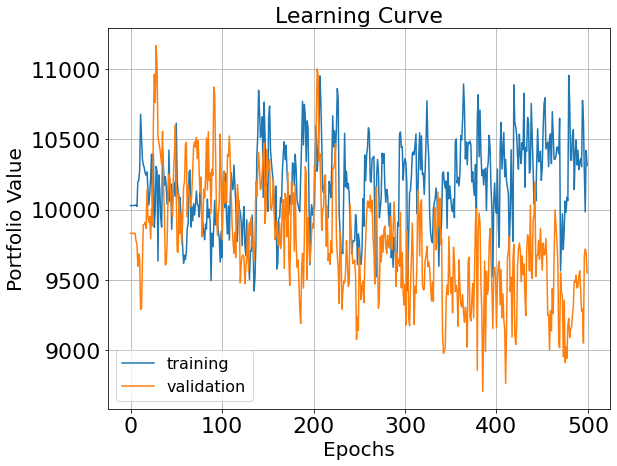

In [74]:
epoch_ranges = np.arange(0, len(train_portfolio_values))
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(epoch_ranges, train_portfolio_values, label="training")
plt.plot(epoch_ranges, val_portfolio_values, label="validation")
plt.title("Learning Curve", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("learning_curve_double_qn_without_train")

In [111]:
ind = 0
max_val = 0
for i in range(len(val_portfolio_values)):
    if val_portfolio_values[i] > max_val:
        max_val = val_portfolio_values[i]
        ind = i
print("index with maximum portfolio value: ", ind)

index with maximum portfolio value:  28


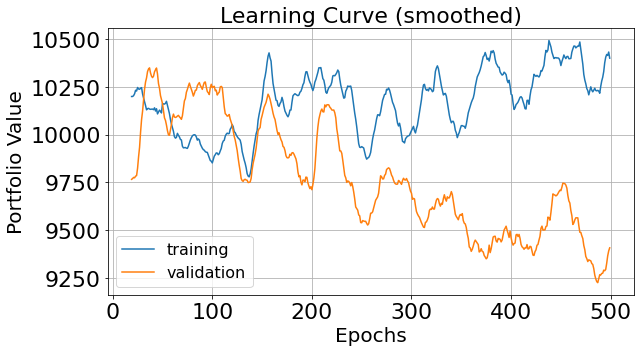

In [149]:
from ads_utils import moving_average
CUT_OFF = 500
WINDOW = 20

x = epoch_ranges[:CUT_OFF]
y = train_portfolio_values[:CUT_OFF]
y = moving_average(y, window=WINDOW)

# Truncate x
x = x[len(x) - len(y):]

#plots reward at each k timestep
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(x, y, label="training")


x = epoch_ranges[:CUT_OFF]
y = val_portfolio_values[:CUT_OFF]
y = moving_average(y, window=WINDOW)

# Truncate x
x = x[len(x) - len(y):]
plt.plot(x, y, label="validation")

plt.title("Learning Curve (smoothed)", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)

# plt.xticks(ticks=np.arange(0, 501, 50))

plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.savefig("smoothed_learning_curve_good")

In [105]:
# Obtained from the script from another computer. - 1_000 epochs
# path = f'./checkpoint_logs/DQN/DQN_plus_{5_000_000}_steps'
path = f'extras/DQN_plus_{5_000_000}_steps'

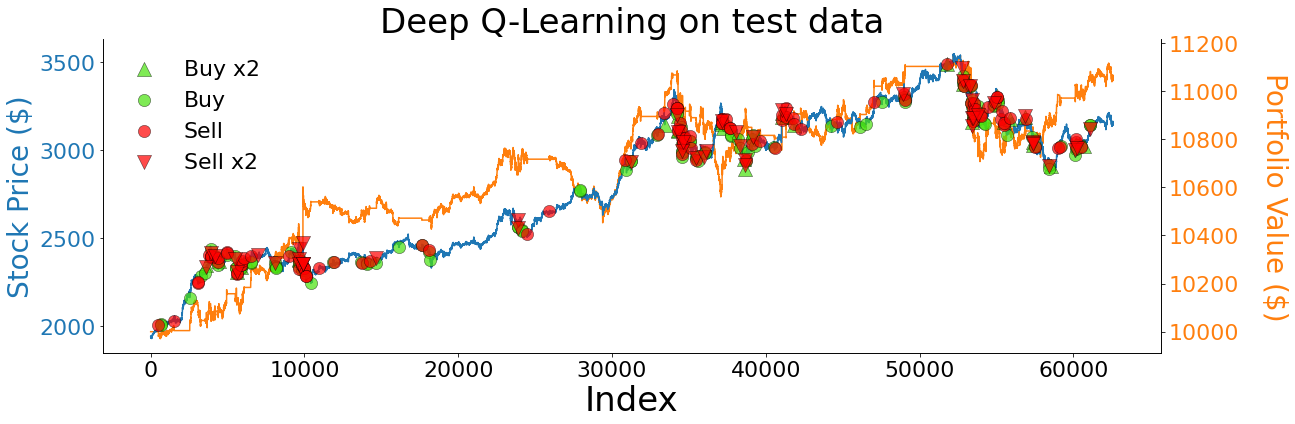

In [106]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 20
SELL, HOLD, BUY = 0, 1, 2
test_range = [i for i in range(6, 1-1, -1)]
test_data = load_data(test_range)


env = Environment(test_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = DQN.load(path)

state = env.reset(rand_start=False)

portfolio_values = []
prices = []
actions = []

for i in range(len(test_data)):
    action, _ = model.predict(state)

    price, portfolio_value = env.get_data()
    
    actions.append(action)
    prices.append(price)
    
    portfolio_values.append(portfolio_value)

    state, reward, done, _ = env.step(action)
    
    if done:
        break
plot(prices, actions, portfolio_values, right_y_adjust=1.12, title="Deep Q-Learning on test data")

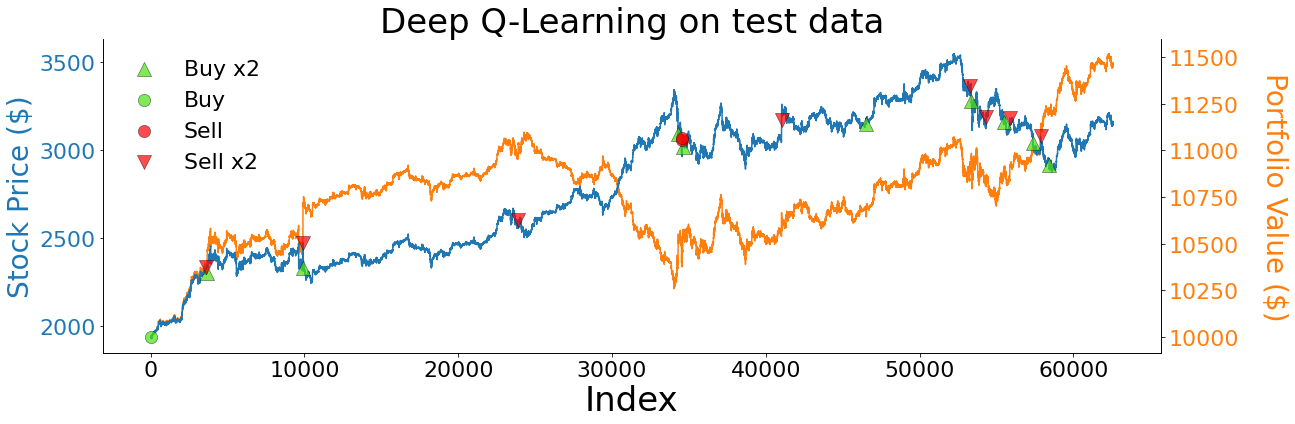

In [113]:
# ind gives the EPOCH with the highest portfolio value in validation data

path = f'./checkpoint_logs/DQN/DQN_{ind*10_000}_steps'

INITIAL_BALANCE = 10_000
PAST_TICKS = 20
SELL, HOLD, BUY = 0, 1, 2
test_range = [i for i in range(6, 1-1, -1)]
test_data = load_data(test_range)


env = Environment(test_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = DQN.load(path)

state = env.reset(rand_start=False)

portfolio_values = []
prices = []
actions = []

for i in range(len(test_data)):
    action, _ = model.predict(state)

    price, portfolio_value = env.get_data()
    
    actions.append(action)
    prices.append(price)
    
    portfolio_values.append(portfolio_value)

    state, reward, done, _ = env.step(action)
    
    if done:
        break
plot(prices, actions, portfolio_values, right_y_adjust=1.12, title="Deep Q-Learning on test data")